In [38]:
import sys; sys.path.append("..") # to fix imports

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from neattime import neattime

from utils.data_utils import load_and_process_data
from utils.model_utils import regression_report, cross_validate_and_plot_regression_model, evaluate_regression_model_performance_by_group

In [39]:
TEST = False

# Load Data and Process into feature matrix and target vector

In [40]:
# load and process data
data = load_and_process_data(train_path= '../data/train.csv', test_path = '../data/test.csv')

data.head()

id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,train,bmi,Sex_encoded
i64,i64,f64,f64,f64,f64,f64,f64,bool,f64,i64
0,36,189.0,82.0,26.0,101.0,41.0,150.0,true,22.955684,0
1,64,163.0,60.0,8.0,85.0,39.7,34.0,true,22.582709,1
2,51,161.0,64.0,7.0,84.0,39.8,29.0,true,24.690405,1
3,20,192.0,90.0,25.0,105.0,40.7,140.0,true,24.414062,0
4,38,166.0,61.0,25.0,102.0,40.6,146.0,true,22.13674,1


In [41]:
feature_names = ['Sex_encoded', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'bmi']
target_name = 'Calories'

In [42]:
# separate train and test data as well as features and target. Check shapes
train_data = data.filter(pl.col('train') == True)
test_data = data.filter(pl.col('train') == False)

X_train = train_data.select(feature_names)
y_train = train_data.select(target_name).to_numpy().flatten() # it's convenient for now to have the features be a polars df but the target is a numpy array

X_test = test_data.select(feature_names)
# no target for the test data 

X_train.shape, y_train.shape, X_test.shape

((750000, 8), (750000,), (250000, 8))

# Simple Linear Models for Comparisons

for the first models, I'm just going to use some basic linear models (linear regression, lasso, and ridge) for comparison later. I expect these to perform slightly worse, although they'll be much simpler, more interpretable, and more efficient.

For lasso and ridge, I won't be modifying coefficients of the L1 and L2 penalties respectively. I'll just stick with the default for now.

In [43]:
regression_reports = {}

In [44]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

In [45]:
linear_model_names_to_models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression (alpha cross-validated)': LassoCV(),
    'Ridge Regression (alpha cross-validated)': RidgeCV(),
}

--------------------------------------------------
Cross-validating and making predictions with Linear Regression...


Time taken: 2.23 seconds
R2: 0.96944
MSE: 118.97047
MAE: 7.9379
RMSE: 10.90736
RMSLE: 0.56671


<Figure size 800x600 with 0 Axes>

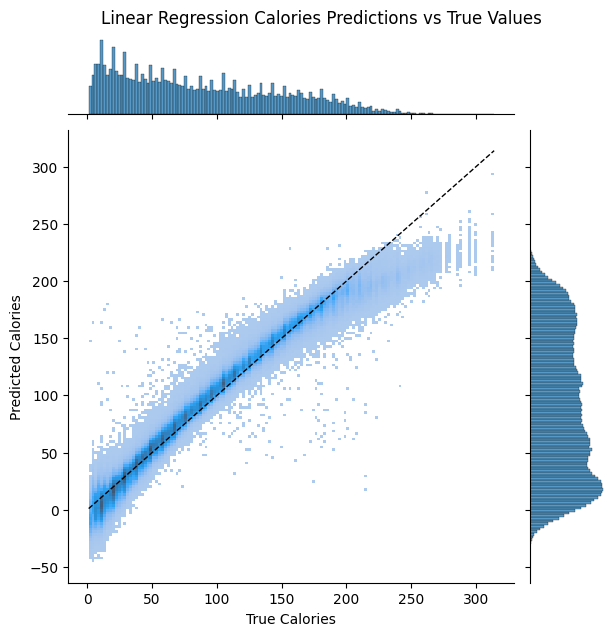

--------------------------------------------------
Cross-validating and making predictions with Lasso Regression (alpha cross-validated)...
Time taken: 3.06 seconds
R2: 0.96751
MSE: 126.49495
MAE: 8.21842
RMSE: 11.247
RMSLE: 0.57805


<Figure size 800x600 with 0 Axes>

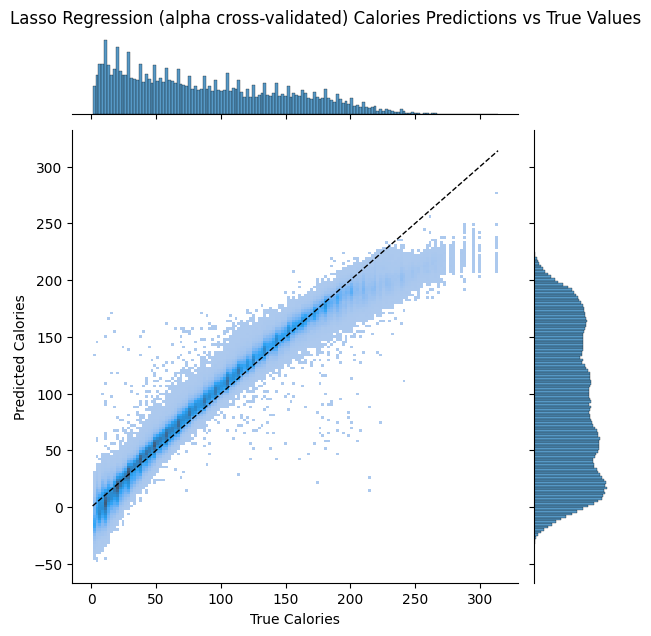

--------------------------------------------------
Cross-validating and making predictions with Ridge Regression (alpha cross-validated)...
Time taken: 1.06 seconds
R2: 0.96944
MSE: 118.97048
MAE: 7.93789
RMSE: 10.90736
RMSLE: 0.56671


<Figure size 800x600 with 0 Axes>

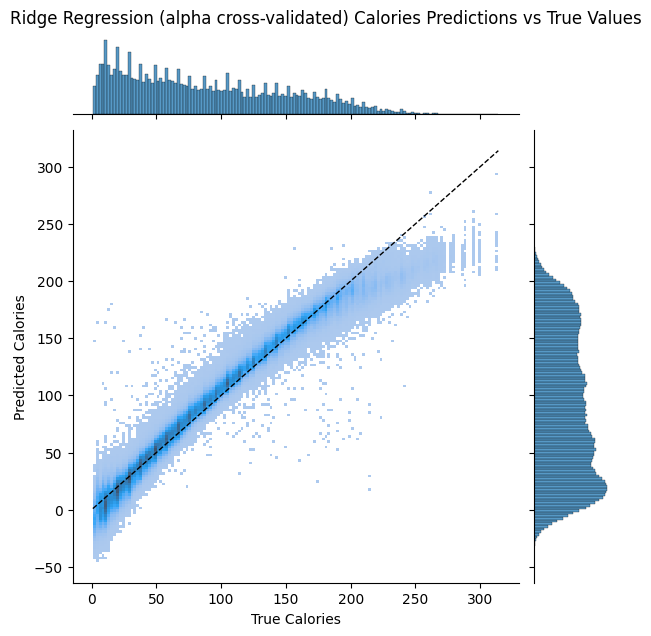

In [46]:
for model_name, model in linear_model_names_to_models.items():
    report = cross_validate_and_plot_regression_model(model, model_name, X_train, y_train, target_name)
    regression_reports[model_name] = report

In [47]:
# what if we just use the duration? This was highly correlated in the analysis notebook (r^2 = 0.9)

X_train_duration = train_data.select(['Duration']).to_numpy()

model = LinearRegression()

model.fit(X_train_duration, y_train)

model.score(X_train_duration, y_train), model.coef_, model.intercept_

(0.9214226262299887, array([7.16939028]), np.float64(-22.276491385550898))

**Takeaways**: The performance on all three of these models is fine. Honestly you could move forward with these and not bother with tuning an Xgboost model

One thing that's interesting is how it looks like there is a nonlinear trend in the predictions vs the true values. It's possible these models would benefit from linearizing body temperature the way I did in the analysis notebook, but I explained there that it causes some numerical stability problems. 

Also, regularization didn't help much (both for L1 and L2)

Overall, I think if you wanted to just use these linear models you'd be fine.

Additionally, you really could just use a linear model with only duration. This would be highly interpretable and would allow people to calculate how many calories they would burn with either a simple calculator or even in their head.

# Initial Random Forest and XGBoost Models (default parameters) + Cross Validation

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict

from xgboost import XGBRegressor

In [49]:
model_name_to_model = {'XGBRegressor (default)': XGBRegressor(random_state=1738),
          'RandomForestRegressor (default)': RandomForestRegressor(random_state=1738)}   

--------------------------------------------------
Cross-validating and making predictions with XGBRegressor (default)...
Time taken: 3.32 seconds
R2: 0.9963
MSE: 14.40368
MAE: 2.35894
RMSE: 3.79522
RMSLE: 0.06588


<Figure size 800x600 with 0 Axes>

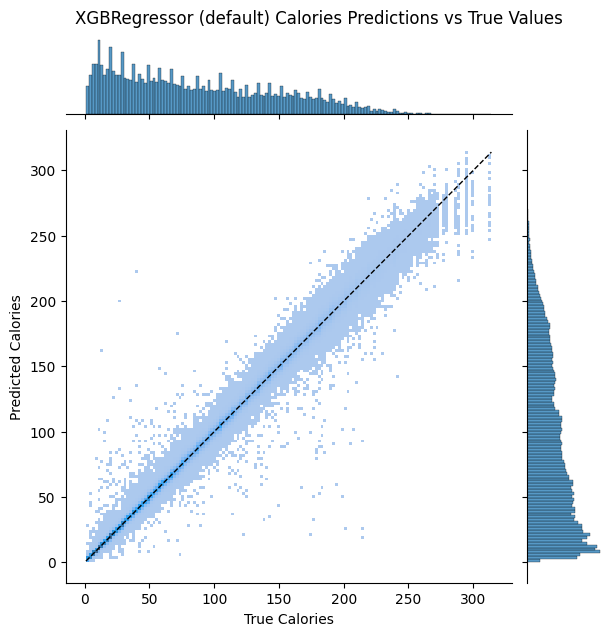

--------------------------------------------------
Cross-validating and making predictions with RandomForestRegressor (default)...
Time taken: 198.27 seconds
R2: 0.99622
MSE: 14.73498
MAE: 2.30015
RMSE: 3.83862
RMSLE: 0.06382


<Figure size 800x600 with 0 Axes>

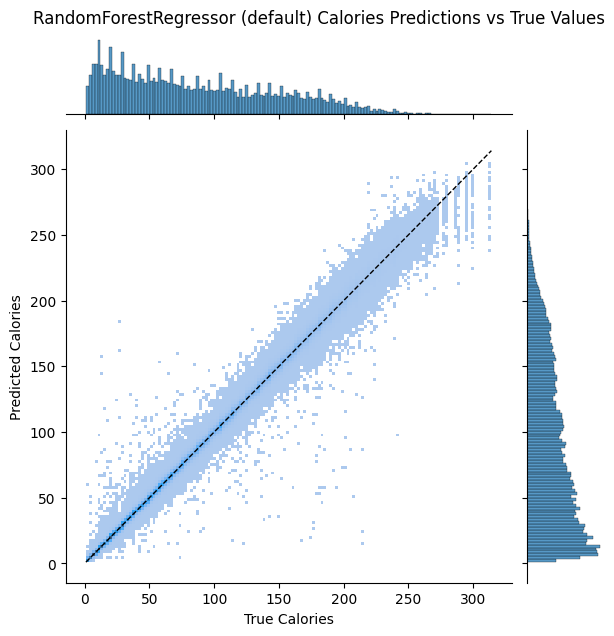

In [50]:
for model_name, model in model_name_to_model.items():
    report = cross_validate_and_plot_regression_model(model, model_name, X_train, y_train, target_name)
    regression_reports[model_name] = report

**Takeaways**: Both models perform well with default parameters and the full training set, although xgboost is much faster. I'll focus on xgb for the ablation study and hyperparameter tuning

# Recursive Feature Elimination with default XGBRegressor

Now, I want to try and determine feature importance and see if reducing the number of features improves or makes no difference to performance. If so, I'll exclude unimportant features for the sake of reducing complexity 

In [51]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

In [52]:
# obtain cross-validated feature importances
cv = 3 if TEST else 10

splitter = KFold(n_splits=cv, shuffle=True, random_state=1738)

feature_importances = np.zeros(shape=(cv, X_train.shape[1]))

for i, (train_idx, test_idx) in enumerate(splitter.split(X_train)):
    X_train_split, X_test_split = X_train[train_idx], X_train[test_idx]
    y_train_split, y_test_split = y_train[train_idx], y_train[test_idx]

    # fit the model
    model = XGBRegressor(random_state=1738)
    model.fit(X_train_split, y_train_split)

    feature_importances[i] = model.feature_importances_

    if i == 0:
        feature_names = model.feature_names_in_

Text(0.5, 1.0, 'Feature Importance Predicting Calorie Expenditure for XGBRegressor')

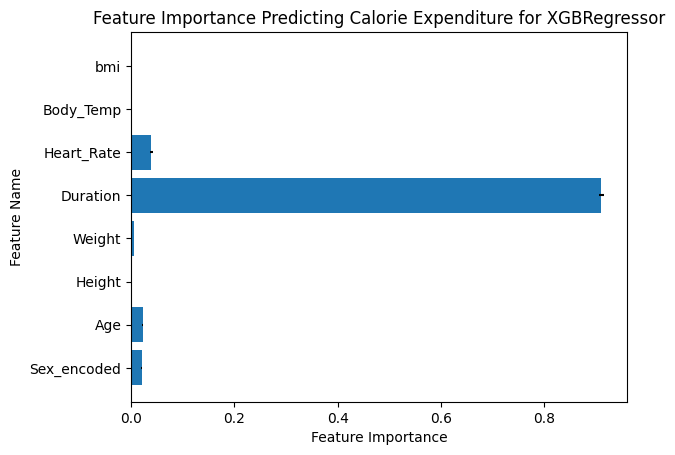

In [53]:
# collect and display the feature importances
feature_importance_means = feature_importances.mean(axis=0)
feature_importance_stds = feature_importances.std(axis=0)

feature_name_to_importance_mean = {feature_name: feature_importance_mean for feature_name, feature_importance_mean in zip(feature_names, feature_importance_means)}
feature_name_to_importance_std = {feature_name: feature_importance_std for feature_name, feature_importance_std in zip(feature_names, feature_importance_stds)}

plt.barh(list(feature_name_to_importance_mean.keys()), list(feature_name_to_importance_mean.values()), xerr=list(feature_name_to_importance_std.values()))
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Predicting Calorie Expenditure for XGBRegressor')

In [54]:
# perform recursive feature elimination with cross-validation
selector = RFECV(estimator=XGBRegressor(random_state=1738), step=1, cv=3 if TEST else 10, scoring='neg_mean_squared_error', n_jobs=-1)

selector = selector.fit(X_train, y_train)

In [55]:
# which features were selected to keep vs remove?
keep_feature_mask = selector.support_

features_to_keep = selector.feature_names_in_[keep_feature_mask]
features_to_remove = selector.feature_names_in_[~keep_feature_mask]

print(f"Features to keep: {features_to_keep}")
print(f"Features to remove: {features_to_remove}")

Features to keep: ['Sex_encoded' 'Age' 'Weight' 'Duration' 'Heart_Rate' 'Body_Temp']
Features to remove: ['Height' 'bmi']


In [56]:
# actually select the features
X_train_selected, X_test_selected = X_train[:, keep_feature_mask], X_test[:, keep_feature_mask]

assert X_train_selected.columns == features_to_keep.tolist(), "Selected features do not match expected features"

X_train_selected.shape, X_test_selected.shape

((750000, 6), (250000, 6))

In [57]:
# fit the model with the selected features as a quick test
model = XGBRegressor(random_state=1738)

y_train_pred = cross_val_predict(model, X_train_selected, y_train, cv=10, n_jobs=-1)

report = regression_report(y_train, y_train_pred)
regression_reports[model_name] = report

for metric_name, metric_value in report.items():
    print(f"{metric_name}: {round(metric_value, 5)}")

R2: 0.99633
MSE: 14.29875
MAE: 2.34624
RMSE: 3.78137
RMSLE: 0.06521


# Hyperparameter Tuning XGBRegressor With Optuna

In [58]:
import optuna
from utils.model_utils import objective_xgb_regressor_rmsle

In [59]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_xgb_regressor_rmsle(trial, X_train_selected.to_numpy(), y_train), n_trials=3 if TEST else 50)

[I 2025-05-18 15:06:46,324] A new study created in memory with name: no-name-99abb550-351c-46d5-a8c3-d305c9d14081
[I 2025-05-18 15:06:52,638] Trial 0 finished with value: 0.06245564586203062 and parameters: {'max_depth': 9, 'min_child_weight': 3.2694948054286446}. Best is trial 0 with value: 0.06245564586203062.
[I 2025-05-18 15:06:55,934] Trial 1 finished with value: 0.07666950164073716 and parameters: {'max_depth': 4, 'min_child_weight': 7.06744706749522}. Best is trial 0 with value: 0.06245564586203062.
[I 2025-05-18 15:07:01,860] Trial 2 finished with value: 0.06306189056850088 and parameters: {'max_depth': 9, 'min_child_weight': 9.739855054572102}. Best is trial 0 with value: 0.06245564586203062.
[I 2025-05-18 15:07:06,876] Trial 3 finished with value: 0.06388554047401138 and parameters: {'max_depth': 7, 'min_child_weight': 3.4706038718920893}. Best is trial 0 with value: 0.06245564586203062.
[I 2025-05-18 15:07:10,692] Trial 4 finished with value: 0.0690304421834328 and parameter

--------------------------------------------------
Cross-validating and making predictions with XGBRegressor (features reduced + best parameters via optuna)
...
Time taken: 3.83 seconds
R2: 0.99642
MSE: 13.9465
MAE: 2.22838
RMSE: 3.7345
RMSLE: 0.06234


<Figure size 800x600 with 0 Axes>

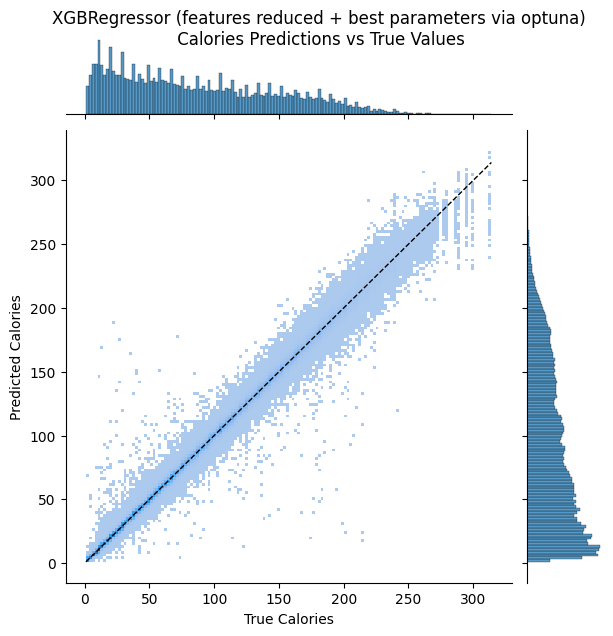

In [60]:
best_params_model = XGBRegressor(**study.best_params, random_state=1738)

best_params_model_name = "XGBRegressor (features reduced + best parameters via optuna)\n"

best_params_report = cross_validate_and_plot_regression_model(best_params_model, best_params_model_name, X_train_selected, y_train, target_name)

regression_reports[best_params_model_name] = best_params_report

In [61]:
# make predictions on test data
best_params_model.fit(X_train_selected, y_train)

y_test_pred = best_params_model.predict(X_test_selected)

# clip the predictions to be non-negative so kaggle can calculate RMSLE
y_test_pred = np.clip(y_test_pred, a_min=0, a_max=None)

In [62]:
# combine predictions and id into single dataframe
test_ids = data.select(pl.col(['id', 'train'])).filter(pl.col('train') == False).select(pl.col('id'))

test_prediction_df = test_ids.with_columns(Calories = y_test_pred)

test_prediction_df.head()

id,Calories
i64,f32
750000,27.494385
750001,108.906723
750002,87.752014
750003,125.885078
750004,76.566536


In [63]:
# save test predictions to a csv
test_predictions_filename = f'../data/test_predictions_{neattime()}.csv'

test_prediction_df.write_csv(test_predictions_filename)

print(f"Test predictions saved to {test_predictions_filename}")

Test predictions saved to ../data/test_predictions_2025-05-18_15-11-49_448097.csv


In [64]:
# save model
best_params_model_path = f'../models/xgboost_{neattime()}.pkl'

pickle.dump(best_params_model, open(best_params_model_path, 'wb'))

print(f"Model saved to {best_params_model_path}")

Model saved to ../models/xgboost_2025-05-18_15-11-49_507208.pkl


# Model Comparison

Text(0.5, 1.0, 'Mean Squared Error Predicting Calorie Expenditure for Different Models')

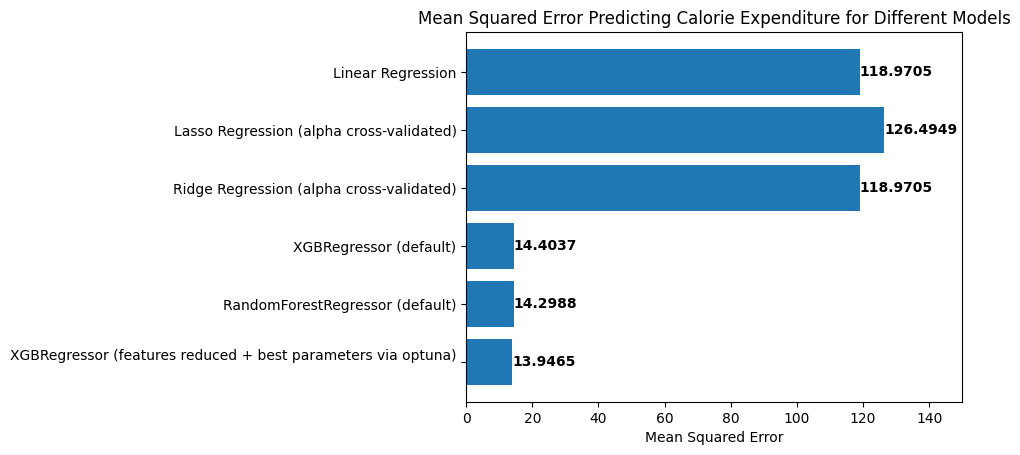

In [83]:
model_mses = {model_name: report['MSE'] for model_name, report in regression_reports.items()}

plt.barh(list(model_mses.keys())[::-1], list(model_mses.values())[::-1])

# add values 
for i, v in enumerate(list(model_mses.values())[::-1]):
    plt.text(v + 0.01, i, str(round(v, 4)), color='black', va='center', fontweight='bold')

plt.xlim(0, 150)
plt.xlabel('Mean Squared Error')
plt.title('Mean Squared Error Predicting Calorie Expenditure for Different Models')

# Model Performance Analysis - Who does it work best/worst for?

In [65]:
from utils.data_utils import SEX_TO_BINARY # so I can map the binary values back to the original values

BINARY_TO_SEX = {v: k for k, v in SEX_TO_BINARY.items()}   

BINARY_TO_SEX

{0: 'male', 1: 'female'}

In [66]:
best_params_model = XGBRegressor(**study.best_params, random_state=1738)

y_pred_train_best_params = cross_val_predict(best_params_model, X_train_selected, y_train, cv=10, n_jobs=-1)  

In [67]:
train_data = train_data.with_columns(pl.Series(name='Calories_Predicted', values=y_pred_train_best_params),
                                     Sex=pl.col('Sex_encoded').replace_strict(BINARY_TO_SEX))

train_data.head()

id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,train,bmi,Sex_encoded,Calories_Predicted,Sex
i64,i64,f64,f64,f64,f64,f64,f64,bool,f64,i64,f32,str
0,36,189.0,82.0,26.0,101.0,41.0,150.0,true,22.955684,0,145.715164,"""male"""
1,64,163.0,60.0,8.0,85.0,39.7,34.0,true,22.582709,1,35.539864,"""female"""
2,51,161.0,64.0,7.0,84.0,39.8,29.0,true,24.690405,1,29.613497,"""female"""
3,20,192.0,90.0,25.0,105.0,40.7,140.0,true,24.414062,0,138.946457,"""male"""
4,38,166.0,61.0,25.0,102.0,40.6,146.0,true,22.13674,1,146.153824,"""female"""


In [68]:
train_data = train_data.with_columns(error = (pl.col('Calories') - pl.col('Calories_Predicted')),
                                        abs_error = (pl.col('Calories') - pl.col('Calories_Predicted')).abs(),
                                     squared_error = (pl.col('Calories') - pl.col('Calories_Predicted'))**2)

train_data.head()

id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,train,bmi,Sex_encoded,Calories_Predicted,Sex,error,abs_error,squared_error
i64,i64,f64,f64,f64,f64,f64,f64,bool,f64,i64,f32,str,f64,f64,f64
0,36,189.0,82.0,26.0,101.0,41.0,150.0,true,22.955684,0,145.715164,"""male""",4.284836,4.284836,18.359818
1,64,163.0,60.0,8.0,85.0,39.7,34.0,true,22.582709,1,35.539864,"""female""",-1.539864,1.539864,2.37118
2,51,161.0,64.0,7.0,84.0,39.8,29.0,true,24.690405,1,29.613497,"""female""",-0.613497,0.613497,0.376378
3,20,192.0,90.0,25.0,105.0,40.7,140.0,true,24.414062,0,138.946457,"""male""",1.053543,1.053543,1.109953
4,38,166.0,61.0,25.0,102.0,40.6,146.0,true,22.13674,1,146.153824,"""female""",-0.153824,0.153824,0.023662


In [69]:
# bin ages so the model performance can be evaluated by age group
age_breaks = [30, 40, 50, 60, 70]
age_group_labels = ['20-30', '31-40', '41-50', '51-60', '61-70', '71+']   

train_data = train_data.with_columns(Age_binned = pl.col('Age').cut(breaks=age_breaks, labels=age_group_labels, left_closed=False))

----------------------------------------------------------------------------------------------------
Evaluating differences in model performance based on Sex
shape: (2, 6)
┌────────┬────────┬────────────┬─────────────┬──────────┬───────────┐
│ Sex    ┆ Count  ┆ Mean Error ┆ Error Stdev ┆ MAE      ┆ MSE       │
│ ---    ┆ ---    ┆ ---        ┆ ---         ┆ ---      ┆ ---       │
│ str    ┆ u32    ┆ f64        ┆ f64         ┆ f64      ┆ f64       │
╞════════╪════════╪════════════╪═════════════╪══════════╪═══════════╡
│ male   ┆ 374279 ┆ -0.001635  ┆ 4.30469     ┆ 2.592018 ┆ 18.530312 │
│ female ┆ 375721 ┆ -0.006044  ┆ 3.004332    ┆ 1.846321 ┆ 9.026021  │
└────────┴────────┴────────────┴─────────────┴──────────┴───────────┘


<Figure size 800x600 with 0 Axes>

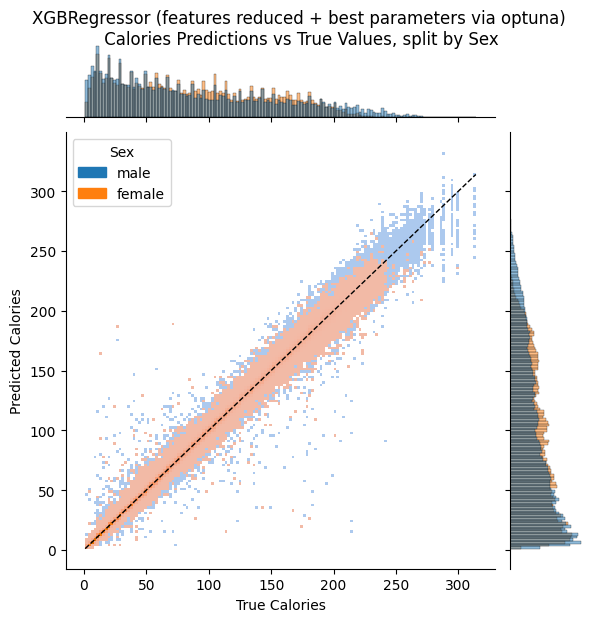

----------------------------------------------------------------------------------------------------
Evaluating differences in model performance based on Age_binned
shape: (6, 6)
┌────────────┬────────┬────────────┬─────────────┬──────────┬───────────┐
│ Age_binned ┆ Count  ┆ Mean Error ┆ Error Stdev ┆ MAE      ┆ MSE       │
│ ---        ┆ ---    ┆ ---        ┆ ---         ┆ ---      ┆ ---       │
│ cat        ┆ u32    ┆ f64        ┆ f64         ┆ f64      ┆ f64       │
╞════════════╪════════╪════════════╪═════════════╪══════════╪═══════════╡
│ 20-30      ┆ 222089 ┆ -0.006274  ┆ 3.544709    ┆ 2.238025 ┆ 12.564943 │
│ 31-40      ┆ 166279 ┆ -0.000127  ┆ 3.028872    ┆ 1.90661  ┆ 9.174013  │
│ 41-50      ┆ 146922 ┆ -0.003659  ┆ 3.116258    ┆ 1.911628 ┆ 9.711013  │
│ 51-60      ┆ 110319 ┆ -0.002331  ┆ 3.553043    ┆ 2.147338 ┆ 12.624006 │
│ 61-70      ┆ 70665  ┆ -0.009036  ┆ 4.668485    ┆ 2.818735 ┆ 21.794521 │
│ 71+        ┆ 33726  ┆ -0.001048  ┆ 6.997302    ┆ 3.93854  ┆ 48.96079  │
└──────

<Figure size 800x600 with 0 Axes>

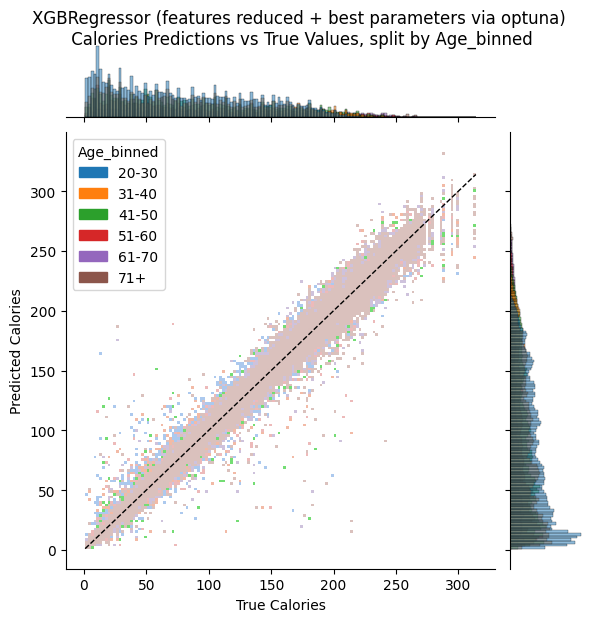

In [70]:
evaluate_regression_model_performance_by_group(train_data, ['Sex', 'Age_binned'], 'Calories', 'Calories_Predicted', best_params_model_name)

**Takeaways**

- in general, there were greater errors for men than women
- the model tended to have higher errors for younger and older age groups, with the best-performing being people aged 31-40
- there was no apparent overall bias in predictions based on age or sex, that is the model did not tend to over- or under-estimate calories expended for any particular group

# Summary

Overall the performance of even just a linear model on this problem is great. Notably, a linear model could be highly interpretable in a way that xgboost isn't.

The linear model could be approximated by and interpreted as:

$$
\text{Calories Burned} = 7 \cdot \text{Number of minutes of exercise} - 22
$$

However, overall the best performance was achieved for xgboost models. 